# Lab Exercise 3

##### BY: AARYANAH MICAH CONSORTE, KYLE GWYNETH MORALES (3CSC)

### ------------------------------------------------------------------------------------

## Checking the Dataset

In [2]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

C:\Users\USER\AppData\Local\Temp\ipykernel_21392\1025810437.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Removing Duplicates

In [3]:
from PIL import Image
import imagehash
import os
from collections import defaultdict

def find_and_remove_exact_duplicates(directory):
    hash_dict = defaultdict(list)

    # Traverse through the directory to find images
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)

                # Open the image and compute its hash using phash
                with Image.open(file_path) as img:
                    img_hash = str(imagehash.phash(img))  # Use phash for perceptual hash

                # Store the file path in the hash dictionary
                hash_dict[img_hash].append(file_path)

    # Identify and remove exact duplicates
    duplicate_paths = []
    for img_hash, paths in hash_dict.items():
        if len(paths) > 1:
            # More than one image has the same hash (exact duplicates)
            duplicate_paths.extend(paths[1:])  # Keep only duplicates, exclude the first occurrence

    # Remove duplicate images
    for path in duplicate_paths:
        os.remove(path)

    print(f"Removed {len(duplicate_paths)} exact duplicate images.")

# Specify the directory containing your image dataset
data_dir = "hair_types"

# Find and remove exact duplicate images using phash
find_and_remove_exact_duplicates(data_dir)


Removed 0 exact duplicate images.


## Data Loading

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (224, 224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 851 files belonging to 3 classes.
Using 681 files for training.
Found 851 files belonging to 3 classes.
Using 170 files for validation.


## Visualizing the Data

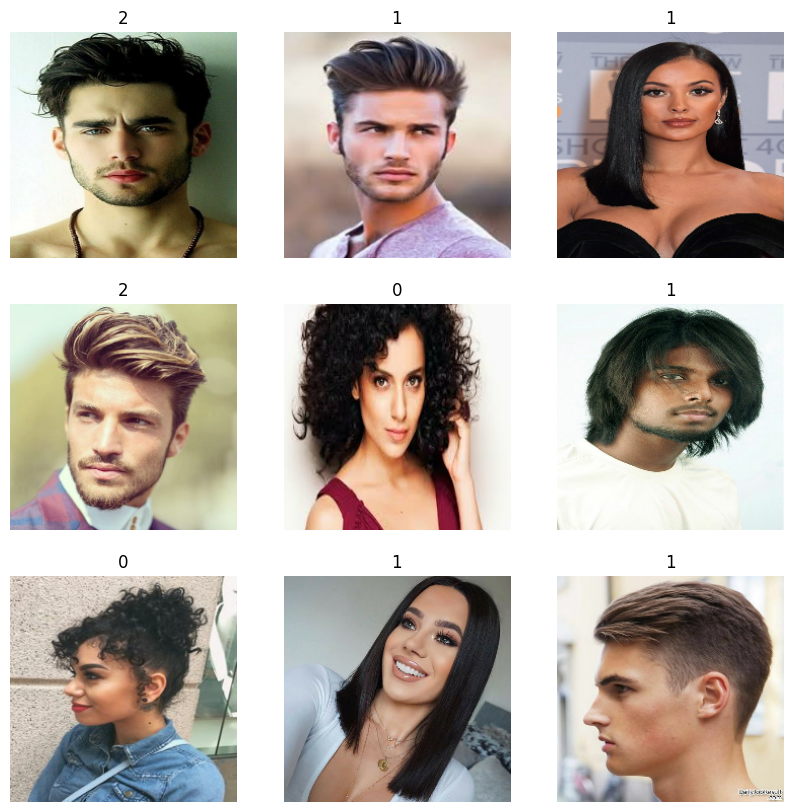

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Building the Model

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.3183 - loss: 9.2239
Epoch 1: val_accuracy improved from -inf to 0.37059, saving model to best_model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step - accuracy: 0.3188 - loss: 9.2048 - val_accuracy: 0.3706 - val_loss: 6.5879
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4443 - loss: 6.0683
Epoch 2: val_accuracy improved from 0.37059 to 0.38824, saving model to best_model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 403ms/step - accuracy: 0.4437 - loss: 6.0567 - val_accuracy: 0.3882 - val_loss: 4.4561
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.4297 - loss: 4.1000
Epoch 3: val_accuracy did not improve from 0.38824
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.4296 - loss: 4.0935 - val_accuracy: 0.3882 - val_loss: 3.1212
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.4539 - loss: 2.8798
Epoch 4: val_accuracy improved from 0.38824 to 0.39412, saving

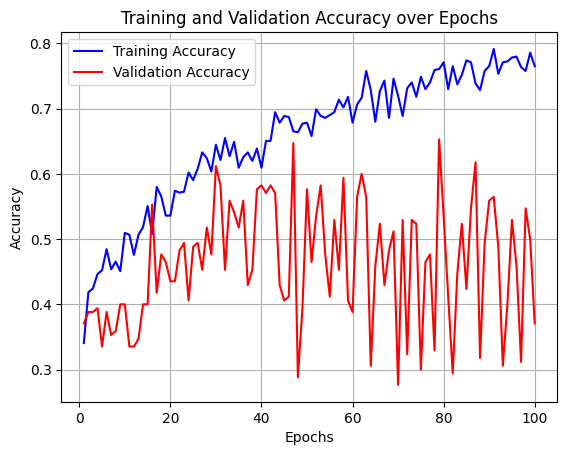

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight

# Define image size
image_size = (224, 224)

l2_regularization_strength = 0.2

# Define the checkpoint filepath to save the best model weights
checkpoint_filepath = "best_model.weights.h5"

# Define callback to save the model weights with the best validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',  # Monitor validation loss
    mode='max',
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',
    patience=100,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    min_delta=0.005,  # Minimum change in validation accuracy to qualify as an improvement
    baseline=0.70,  # Validation accuracy baseline to reach before stopping
    restore_best_weights=True  # Restore the weights of the best model
)

# Define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(l2_regularization_strength)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Visualize the model
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model (replace train_ds and val_ds with your dataset)
epochs = 150

# Train the model
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback, early_stopping_callback])

# Get training and validation accuracy from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Define and load the best model
best_model = tf.keras.models.Sequential()
best_model.add(tf.keras.Input(shape=image_size + (3,)))
best_model.add(layers.Rescaling(1.0 / 255))

best_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same'))
best_model.add(layers.BatchNormalization())
best_model.add(layers.Activation("relu"))
best_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

best_model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'))
best_model.add(layers.BatchNormalization())
best_model.add(layers.Activation("relu"))
best_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

best_model.add(layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'))
best_model.add(layers.BatchNormalization())
best_model.add(layers.Activation("relu"))
best_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

best_model.add(layers.GlobalAveragePooling2D())
best_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(l2_regularization_strength)))
best_model.add(layers.BatchNormalization())
best_model.add(layers.Activation("relu"))
best_model.add(layers.Dropout(0.5))
best_model.add(layers.Dense(3, activation='softmax'))

# Load the weights of the best model from checkpoint
best_model.load_weights(checkpoint_filepath)


## Making Predictions

In [96]:
# Define the file paths for the images
curly_image_paths = [
    "hair_types/Curly_Hair/Curly_Hair_1.jpg",
    "hair_types/Curly_Hair/Curly_Hair_150.jpg",
    "hair_types/Curly_Hair/Curly_Hair_300.jpg"
]

straight_image_paths = [
    "hair_types/Straight_Hair/Straight_Hair_1.jpg",
    "hair_types/Straight_Hair/Straight_Hair_150.jpg",
    "hair_types/Straight_Hair/Straight_Hair_300.jpg"
]

wavy_image_paths = [
    "hair_types/Wavy_Hair/Wavy_Hair_1.jpg",
    "hair_types/Wavy_Hair/Wavy_Hair_150.jpg",
    "hair_types/Wavy_Hair/Wavy_Hair_300.jpg"
]

# Define a function to load and predict on an image
def load_and_predict(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = best_model.predict(img_array)
    return predictions

# Iterate over the image paths for each hair class
print("CURLY HAIR PREDICTIONS")
for path in curly_image_paths:
    predictions = load_and_predict(path)
    print("This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
          % tuple(predictions[0]))

print("\nSTRAIGHT HAIR PREDICTIONS")
for path in straight_image_paths:
    predictions = load_and_predict(path)
    print("This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
          % tuple(predictions[0]))

print("\nWAVY HAIR PREDICTIONS")
for path in wavy_image_paths:
    predictions = load_and_predict(path)
    print("This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
          % tuple(predictions[0]))


CURLY HAIR PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
This image is 1.00 percent curly hair, 0.00 percent straight hair, and 0.00 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
This image is 1.00 percent curly hair, 0.00 percent straight hair, and 0.00 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
This image is 1.00 percent curly hair, 0.00 percent straight hair, and 0.00 percent wavy hair.

STRAIGHT HAIR PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image is 0.03 percent curly hair, 0.95 percent straight hair, and 0.02 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image is 0.02 percent curly hair, 0.90 percent straight hair, and 0.08 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
This image is 0.03 percent curly hair, 0.97 percent straight hair, and 0.00 percent wavy hair.

WAVY HAIR PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image is 0.05 percent curly hair, 0.25 percent straight hair, and 0.70 percent wavy ha

## Visualizing the Model's Architecture

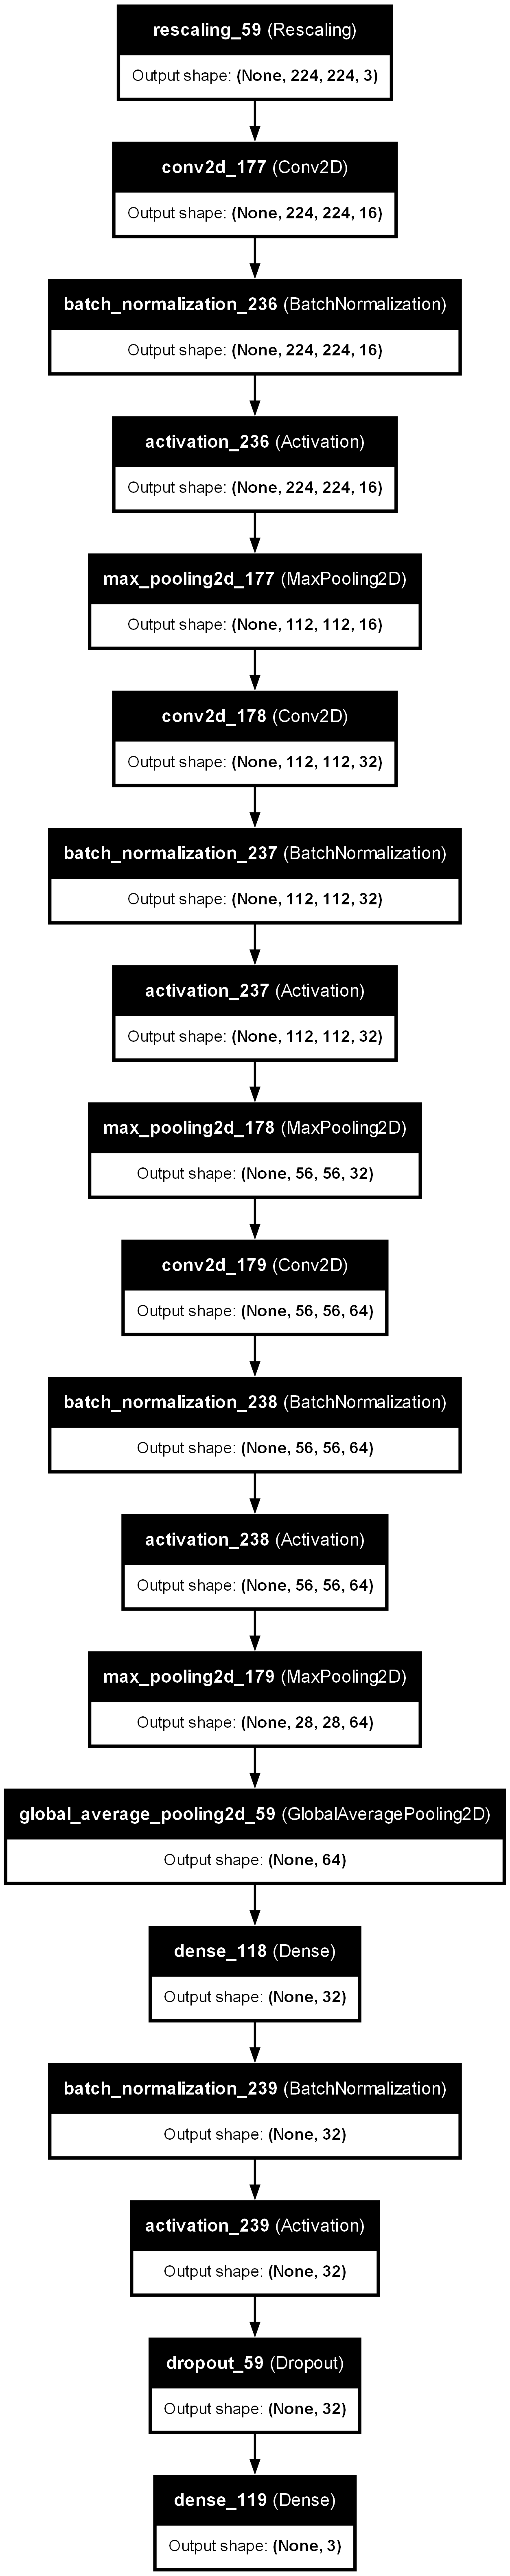

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Display the model architecture
tf.keras.utils.plot_model(best_model, show_shapes=True, show_layer_names=True, to_file='BestModel_Architecture.png')